In [48]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


Step 1. 인물모드 직접 해 보기

여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.

인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.

- Sementic Segmentation / Instance Segmentation 을 비교하기위해 중첩된 동일 사물(label 범위 내에서)이 찍힌 사진 확보.


배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

- 원리는 같다. 목표 타겟이 아니면 다른 사진 출력. (같은 크기의 이미지가 필요할 것 같다.)

- Agriculture
- Segmentation models are used in agriculture to detect bad crops and pests. Vision-based algorithms learn to detect infestations and diseases in crops. Integrating digital twin technology in agriculture complements these advanced segmentation models, providing a comprehensive and dynamic view of agricultural systems to enhance crop management and yield predictions. The automated system is further programmed to alert the farmer to the precise location of the anomaly or trigger pesticides to prevent damage.

In [49]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [50]:
import os
os.getenv('HOME')

'/aiffel'

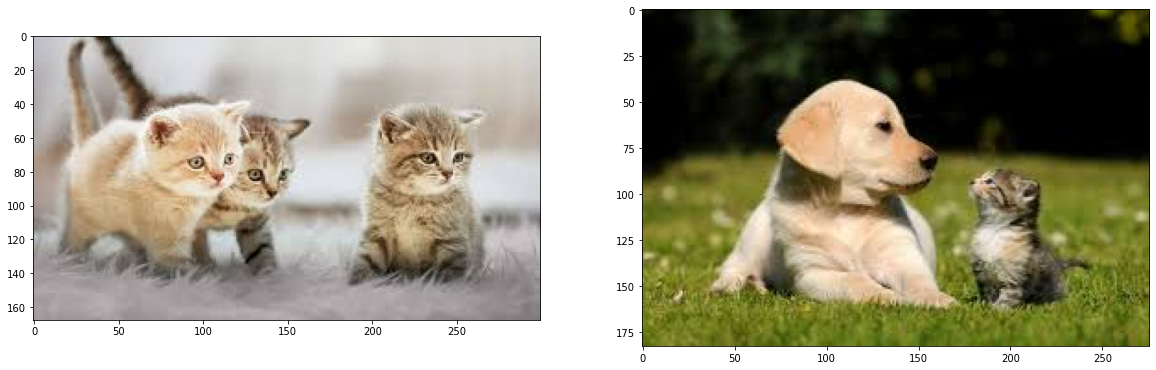

In [51]:
path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
cat_path = path+'cats1.jpeg'
cat_dog_path = path+'kitten_and_dog.jpeg'

#save original image
cat_img_origin = cv2.imread(cat_path)
catdog_img_origin = cv2.imread(cat_dog_path)

plt.subplots(figsize=(20,10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(cat_img_origin,cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(catdog_img_origin,cv2.COLOR_BGR2RGB))
plt.show()

Seperate(Classify) subjects based on sementicity. (background, cat, dog, human, chair...etc)

In [20]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir,'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7c8d3a1cf850>)

In [24]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [26]:
segvalues, output = model.segmentAsPascalvoc(cat_path)

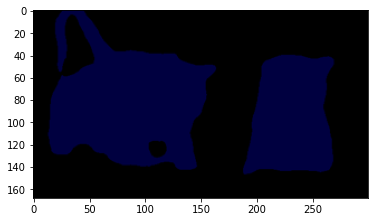

In [30]:
plt.imshow(output)

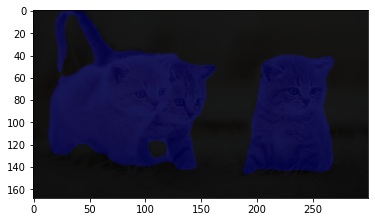

In [52]:
plt.imshow(cv2.addWeighted(cv2.cvtColor(cat_img_origin,cv2.COLOR_BGR2RGB),0.1,output,1,0))

In [27]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [60]:
segvalues['class_ids']

array([0, 8])

In [53]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [54]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [69]:
seg_color = colormap[LABEL_NAMES.index('cat')]
print(seg_color)
seg_color = [0,0,64]
print(seg_color)

[64  0  0]
[0, 0, 64]


(168, 300)


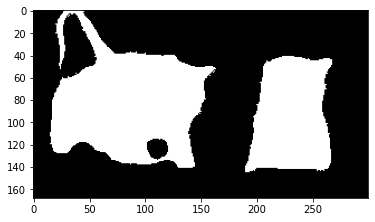

In [70]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [71]:
print(seg_map)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


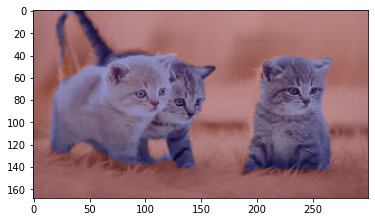

In [81]:
cat_img_show = cat_img_origin.copy()
cat_img_mask = seg_map.astype(np.uint8)*255
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)

cat_img_show = cv2.addWeighted(cv2.cvtColor(cat_img_show,cv2.COLOR_BGR2RGB),0.6,cat_color_mask,0.4,0)

plt.imshow(cat_img_show)
plt.show()

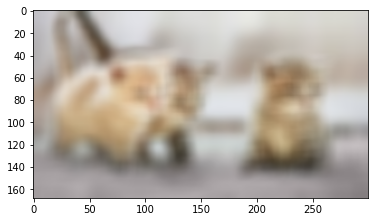

In [85]:
cat_img_origin_blur = cv2.blur(cat_img_origin, (13,13))

plt.imshow(cv2.cvtColor(cat_img_origin_blur,cv2.COLOR_BGR2RGB))
plt.show()

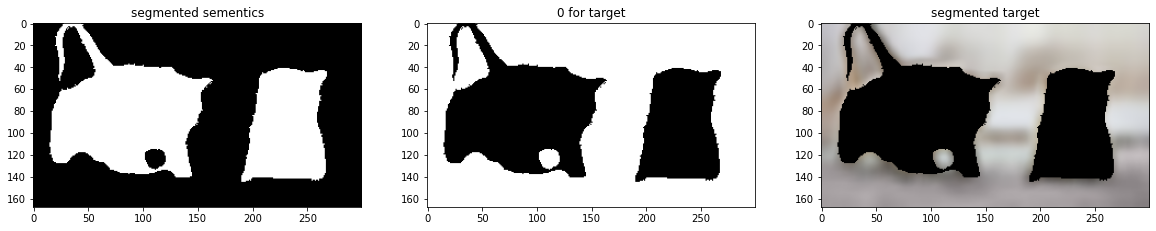

In [97]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
plt.subplots(figsize=(20,20))
plt.subplot(131)
plt.title('segmented sementics')
plt.imshow(cat_img_mask_color)
#image reverse -> 0 values for target
img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
plt.subplot(132)
plt.title('0 for target')
plt.imshow(img_bg_mask)

img_bg_blur = cv2.bitwise_and(cat_img_origin_blur,img_bg_mask)
plt.subplot(133)
plt.imshow(cv2.cvtColor(img_bg_blur,cv2.COLOR_BGR2RGB))
plt.title('segmented target')
plt.show()

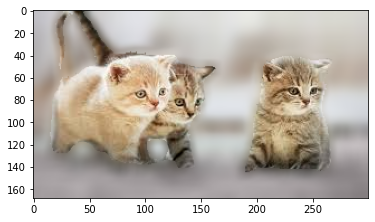

In [98]:
cat_img_bk_blured = np.where(img_bg_mask==0,cat_img_origin,cat_img_origin_blur)
cat_img_bk_blured = cv2.cvtColor(cat_img_bk_blured,cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_bk_blured)
plt.show()

다른 사물 동시에 Segmentation (dog and cat)

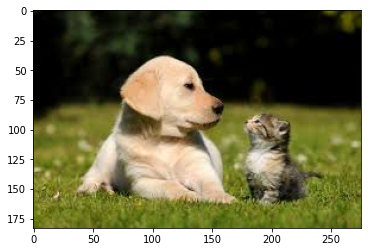

In [99]:
cat_dog_path = path+'kitten_and_dog.jpeg'
catdog_img_origin = cv2.imread(cat_dog_path)

plt.imshow(cv2.cvtColor(catdog_img_origin,cv2.COLOR_BGR2RGB))
plt.show()

In [100]:
cd_segvalues, cd_output = model.segmentAsPascalvoc(cat_dog_path)

In [101]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

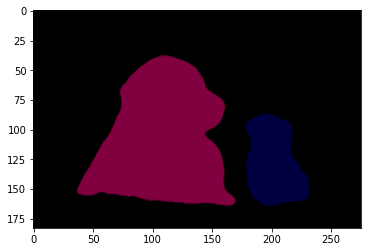

In [103]:
plt.imshow(cd_output)
plt.show()

In [105]:
for class_id in cd_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
dog


In [119]:
print(len(cd_segvalues['class_ids']))

3


In [125]:
segs = []
for i,seg in enumerate(cd_segvalues['class_ids']):
    seg_color=colormap[seg]
    seg_color=[seg_color[2],seg_color[1],seg_color[0]]
    print(seg_color)
    segs.append([seg_color])

[0, 0, 0]
[0, 0, 64]
[128, 0, 64]


In [127]:
print(segs[0])

[[0, 0, 0]]


#seg_map try : 동시에 분류 / 불리언 각각 연산 -> | 연산으로 합치기.

In [134]:
cat_seg_map = np.all(cd_output==segs[1],axis=-1)
dog_seg_map = np.all(cd_output==segs[2],axis=-1)
cd_seg_map = cat_seg_map | dog_seg_map

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


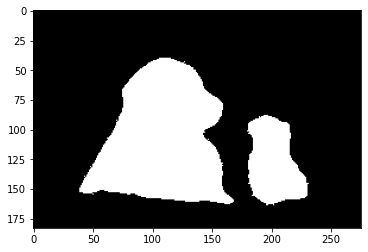

In [135]:
plt.imshow(cd_seg_map, cmap='gray')
plt.show()

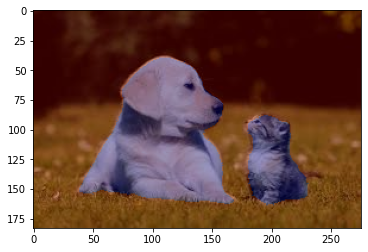

In [142]:
cd_img_show = catdog_img_origin.copy()
cd_img_mask = cd_seg_map.astype(np.uint8)*255
cd_color_mask = cv2.applyColorMap(cd_img_mask, cv2.COLORMAP_JET)

cd_img_show = cv2.addWeighted(cv2.cvtColor(cd_img_show,cv2.COLOR_BGR2RGB),0.6,cd_color_mask,0.4,0)

plt.imshow(cd_img_show)
plt.show()

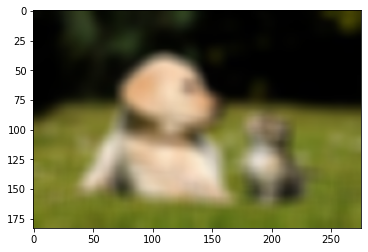

In [144]:
cd_img_origin_blur = cv2.blur(catdog_img_origin, (13,13))

plt.imshow(cv2.cvtColor(cd_img_origin_blur,cv2.COLOR_BGR2RGB))
plt.show()

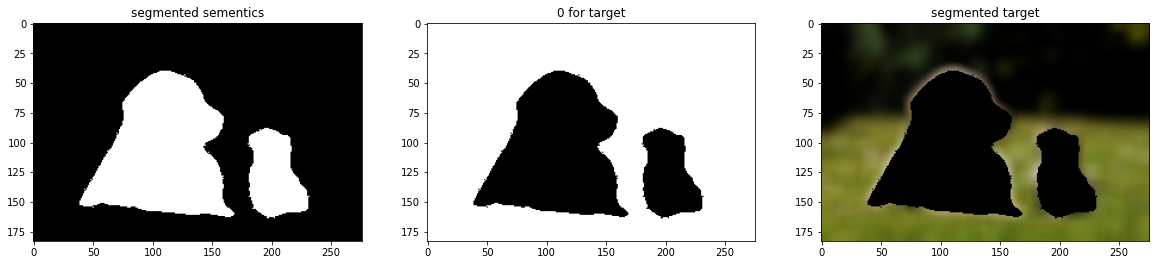

In [146]:
cd_img_mask_color = cv2.cvtColor(cd_img_mask, cv2.COLOR_GRAY2BGR)
plt.subplots(figsize=(20,20))
plt.subplot(131)
plt.title('segmented sementics')
plt.imshow(cd_img_mask_color)
#image reverse -> 0 values for target
cd_img_bg_mask = cv2.bitwise_not(cd_img_mask_color)
plt.subplot(132)
plt.title('0 for target')
plt.imshow(cd_img_bg_mask)

cd_img_bg_blur = cv2.bitwise_and(cd_img_origin_blur,cd_img_bg_mask)
plt.subplot(133)
plt.imshow(cv2.cvtColor(cd_img_bg_blur,cv2.COLOR_BGR2RGB))
plt.title('segmented target')
plt.show()

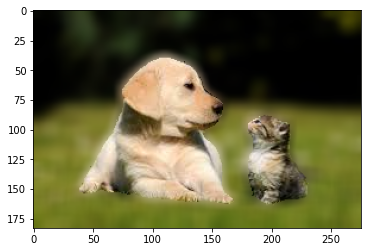

In [149]:
cd_img_bk_blured = np.where(cd_img_bg_mask==0,catdog_img_origin,cd_img_origin_blur)
cd_img_bk_blured = cv2.cvtColor(cd_img_bk_blured,cv2.COLOR_BGR2RGB)
plt.imshow(cd_img_bk_blured)
plt.show()

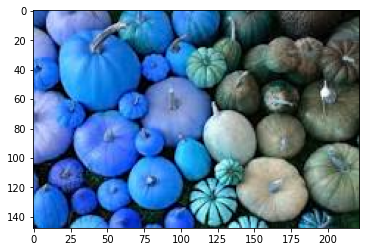

In [160]:
#배경 바꾸기
bk_img_path=os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpeg'
bk_img = cv2.imread(bk_img_path)

plt.imshow(bk_img)

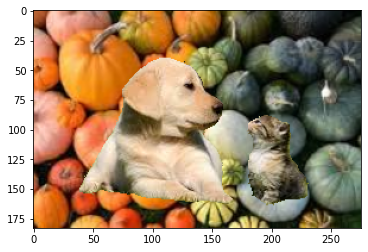

In [162]:
#크기 맞추기
bk_img = cv2.resize(bk_img,(catdog_img_origin.shape[1],catdog_img_origin.shape[0]))


cd_img_bk_changed = np.where(cd_img_bg_mask==0,catdog_img_origin,bk_img)
cd_img_bk_changed = cv2.cvtColor(cd_img_bk_changed,cv2.COLOR_BGR2RGB)
plt.imshow(cd_img_bk_changed)
plt.show()


Step 2. 사진에서 문제점 찾기

Drawbacks of Semantic Segmentation
Despite its various applications, semantic segmentation has drawbacks that limit its applications in real-world scenarios.
Even though it predicts a class label for each pixel, it cannot distinguish between different instances of the same object.
For example, if we use an image of a crowd, the model will recognize pixels associated with humans but will not know where a person stands. 

This is more troublesome with overlapping objects since the model creates a unified mask without clear instance boundaries.
Hence the model cannot be used in certain situations, such as counting the number of objects present.
Panoptic segmentation solves this problem by combining semantic and instance segmentation to provide more information regarding the image.

Step 3. 해결 방법을 제안해 보기

